In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import pvlib
import numpy as np 
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('df_mes.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime_utc'] = df['datetime'].dt.tz_localize('UTC')
df['datetime_local'] = df['datetime_utc'].dt.tz_convert('America/Sao_Paulo')
display(df)

,Month,DHI,DNI,GHI,Solar Zenith Angle,Wind Speed,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine,datetime_utc,datetime_local
0,1,0,0,0,133.35,2.4,2019-01-01 00:00:00,15,228.129189,0.000000,0.000000,1.000000,2019-01-01 00:00:00+00:00,2018-12-31 22:00:00-02:00
1,1,0,0,0,133.16,2.3,2019-01-01 00:30:00,15,222.677718,0.000000,0.130526,0.991445,2019-01-01 00:30:00+00:00,2018-12-31 22:30:00-02:00
2,1,0,0,0,131.85,2.2,2019-01-01 01:00:00,15,216.419942,0.000000,0.258819,0.965926,2019-01-01 01:00:00+00:00,2018-12-31 23:00:00-02:00
3,1,0,0,0,129.51,2.0,2019-01-01 01:30:00,15,209.279223,0.000000,0.382683,0.923880,2019-01-01 01:30:00+00:00,2018-12-31 23:30:00-02:00
4,1,0,0,0,126.28,1.9,2019-01-01 02:00:00,15,201.247715,0.000000,0.500000,0.866025,2019-01-01 02:00:00+00:00,2019-01-01 00:00:00-02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12,0,0,0,119.37,2.8,2019-12-31 21:30:00,60,246.845935,9.925587,-0.608761,0.793353,2019-12-31 21:30:00+00:00,2019-12-31 18:30:00-03:00
17516,12,0,0,0,123.75,2.8,2019-12-31 22:00:00,15,243.925505,0.000000,-0.500000,0.866025,2019-12-31 22:00:00+00:00,2019-12-31 19:00:00-03:00
17517,12,0,0,0,127.48,2.7,2019-12-31 22:30:00,15,240.669099,0.000000,-0.382683,0.923880,2019-12-31 22:30:00+00:00,2019-12-31 19:30:00-03:00
17518,12,0,0,0,130.42,2.7,2019-12-31 23:00:00,15,237.004479,0.000000,-0.258819,0.965926,2019-12-31 23:00:00+00:00,2019-12-31 20:00:00-03:00


Divisão do algoritmo nos períodos de backtracking (5:30-7:30 e 15:30-20:00)

Se o ângulo ótimo for maior que do pvlib mantem-se o do pvlib 

In [4]:
from datetime import time 

'''
# Condições para intervalos que não atravessam a meia-noite
cond_early_morning = (df['datetime_local'].dt.time >= time(5, 30)) & (df['datetime_local'].dt.time <= time(7, 30))
cond_afternoon = (df['datetime_local'].dt.time >= time(15, 30))
# Condição para intervalo que atravessa a meia-noite
cond_late_night = (df['datetime_local'].dt.time <= time(5, 30))

# Aplicação das condições
df['Angulo real'] = np.where(
    cond_early_morning | cond_afternoon | cond_late_night,
    np.where(abs(df['Angulo']) > abs(df['tracker_theta']), df['tracker_theta'], df['Angulo']),
    df['Angulo']
)

display(df)

'''
#np.where(condição, valor_se_verdadeiro, valor_se_falso)
df['Angulo real'] = np.where(
    ((df['datetime_local'].dt.time >= time(5,30)) & (df['datetime_local'].dt.time <= time(7,30))) |
    ((df['datetime_local'].dt.time >= time(15,30)) & (df['datetime_local'].dt.time <= time(18,00))),
    np.where(abs(df['Angulo']) > abs(df['tracker_theta']), df['tracker_theta'], df['Angulo']),
    df['Angulo']
)

display(df)


,Month,DHI,DNI,GHI,Solar Zenith Angle,Wind Speed,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine,datetime_utc,datetime_local,Angulo real
0,1,0,0,0,133.35,2.4,2019-01-01 00:00:00,15,228.129189,0.000000,0.000000,1.000000,2019-01-01 00:00:00+00:00,2018-12-31 22:00:00-02:00,15.0
1,1,0,0,0,133.16,2.3,2019-01-01 00:30:00,15,222.677718,0.000000,0.130526,0.991445,2019-01-01 00:30:00+00:00,2018-12-31 22:30:00-02:00,15.0
2,1,0,0,0,131.85,2.2,2019-01-01 01:00:00,15,216.419942,0.000000,0.258819,0.965926,2019-01-01 01:00:00+00:00,2018-12-31 23:00:00-02:00,15.0
3,1,0,0,0,129.51,2.0,2019-01-01 01:30:00,15,209.279223,0.000000,0.382683,0.923880,2019-01-01 01:30:00+00:00,2018-12-31 23:30:00-02:00,15.0
4,1,0,0,0,126.28,1.9,2019-01-01 02:00:00,15,201.247715,0.000000,0.500000,0.866025,2019-01-01 02:00:00+00:00,2019-01-01 00:00:00-02:00,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12,0,0,0,119.37,2.8,2019-12-31 21:30:00,60,246.845935,9.925587,-0.608761,0.793353,2019-12-31 21:30:00+00:00,2019-12-31 18:30:00-03:00,60.0
17516,12,0,0,0,123.75,2.8,2019-12-31 22:00:00,15,243.925505,0.000000,-0.500000,0.866025,2019-12-31 22:00:00+00:00,2019-12-31 19:00:00-03:00,15.0
17517,12,0,0,0,127.48,2.7,2019-12-31 22:30:00,15,240.669099,0.000000,-0.382683,0.923880,2019-12-31 22:30:00+00:00,2019-12-31 19:30:00-03:00,15.0
17518,12,0,0,0,130.42,2.7,2019-12-31 23:00:00,15,237.004479,0.000000,-0.258819,0.965926,2019-12-31 23:00:00+00:00,2019-12-31 20:00:00-03:00,15.0


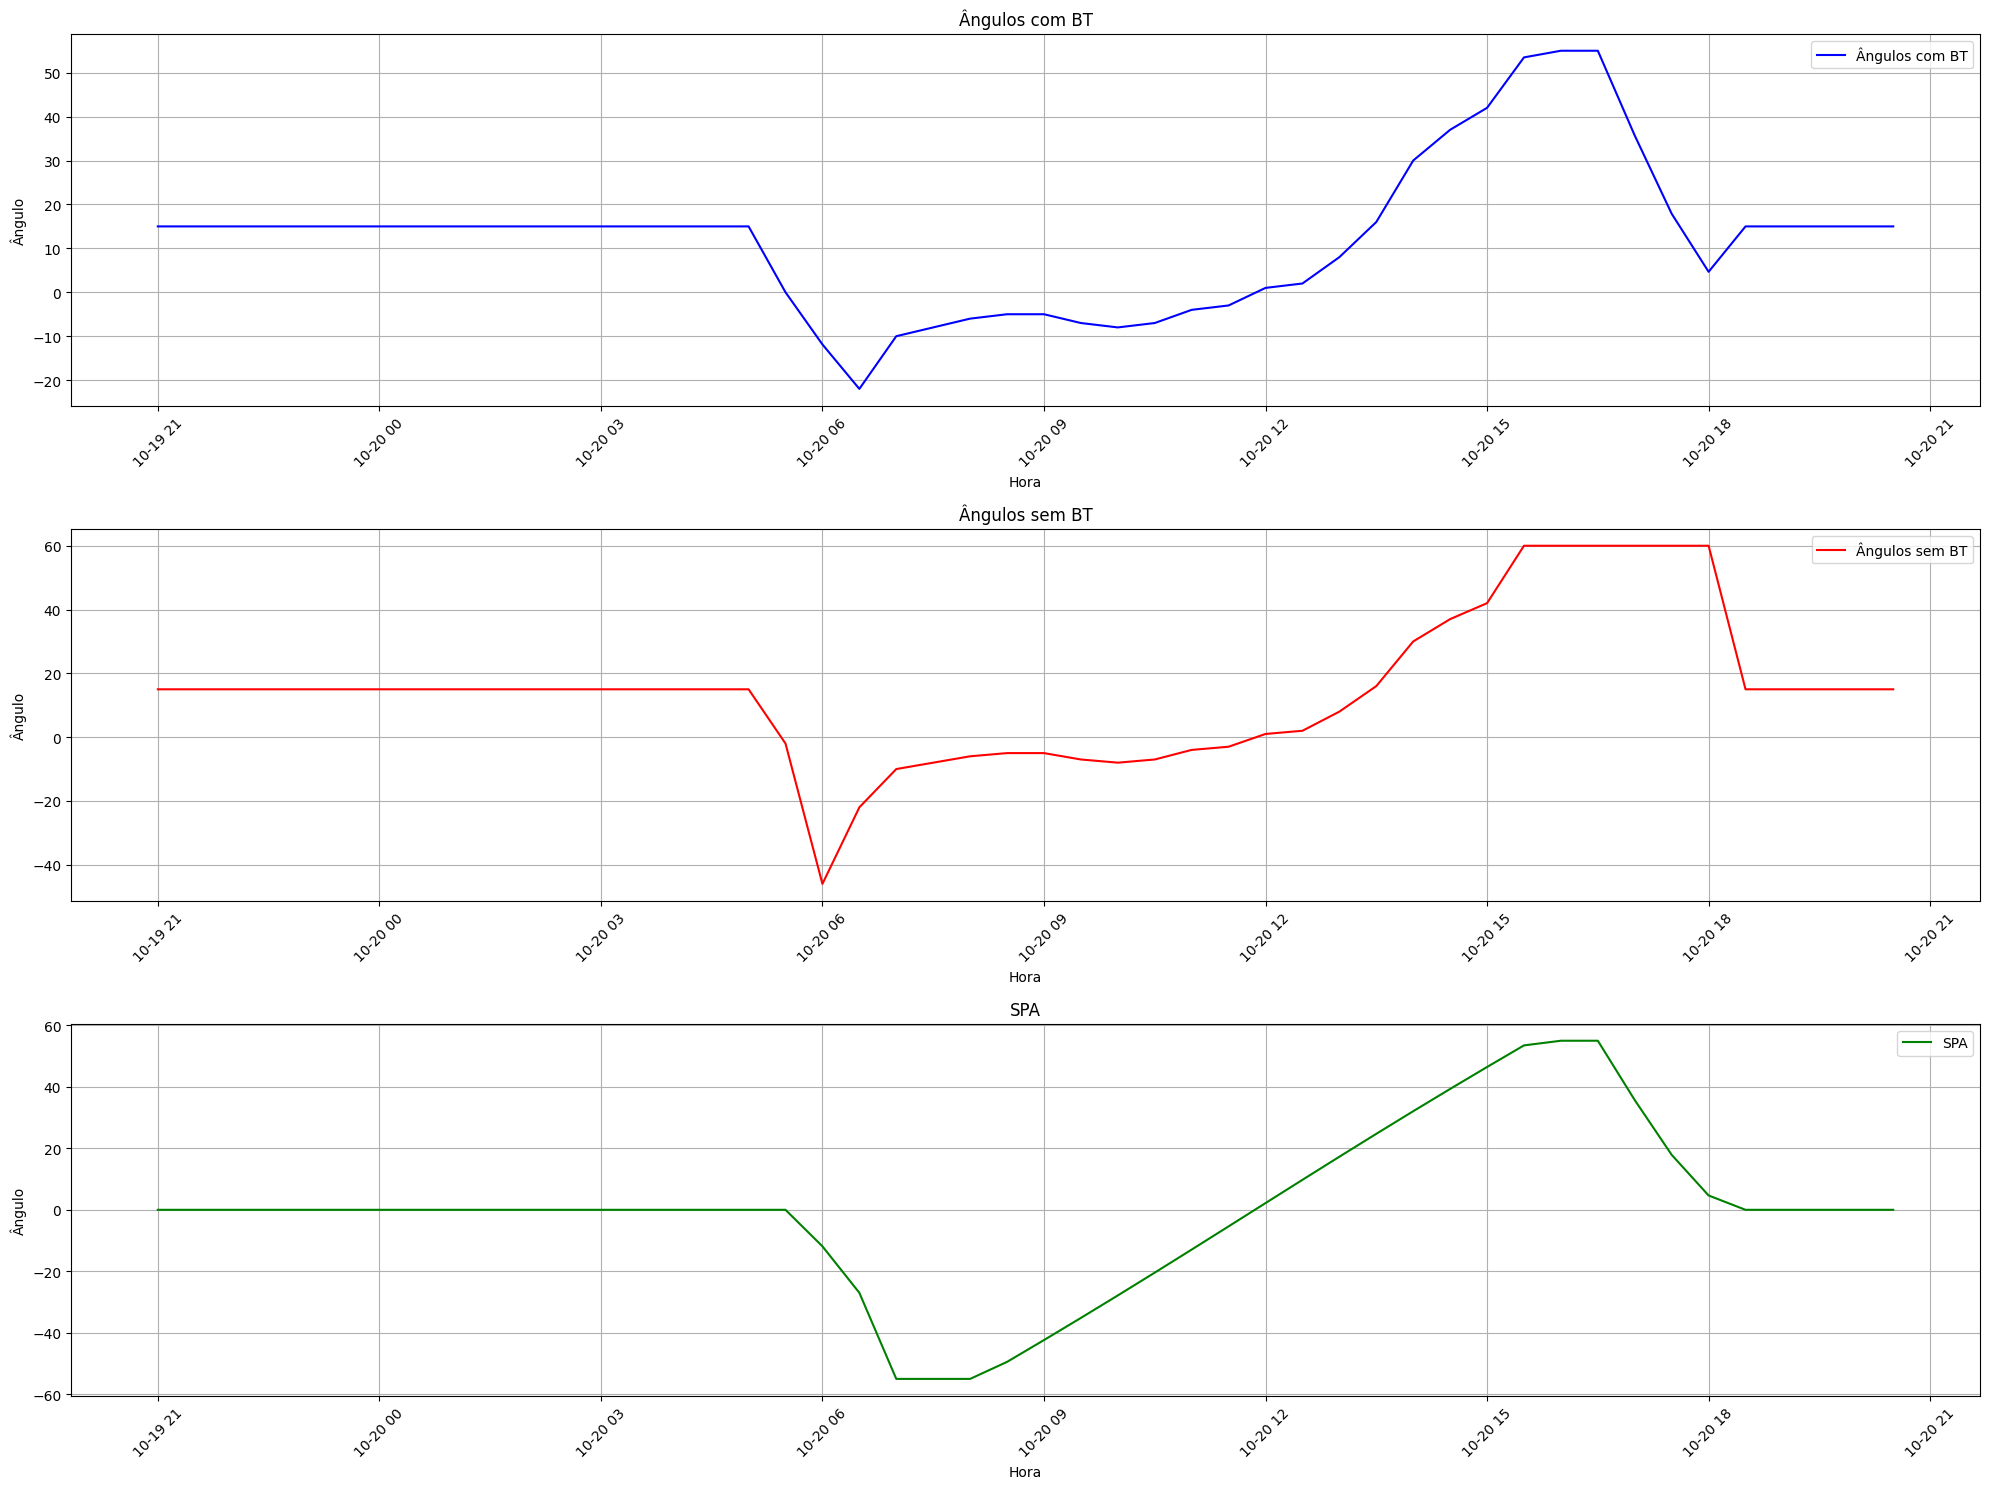

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Selecione o intervalo de datetime correspondente aos índices desejados [14016:14064]  
datetime_selecionados = df['datetime_local'][14016:14064]    
angulosBT_selecionados = df['Angulo real'][14016:14064]   
angulos_selecionados = df['Angulo'][14016:14064]  
angulos = df['tracker_theta'][14016:14064]   

# Criar a figura e os subplots (3 linhas, 1 coluna)
fig, axs = plt.subplots(3, 1, figsize=(20, 15))

# Gráfico 1: Ângulos com BT
axs[0].plot(datetime_selecionados, angulosBT_selecionados, label='Ângulos com BT', color='blue')
axs[0].set_title('Ângulos com BT')
axs[0].set_xlabel('Hora')
axs[0].set_ylabel('Ângulo')
axs[0].legend()
axs[0].grid(True)
axs[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Ângulos sem BT
axs[1].plot(datetime_selecionados, angulos_selecionados, label='Ângulos sem BT', color='red')
axs[1].set_title('Ângulos sem BT')
axs[1].set_xlabel('Hora')
axs[1].set_ylabel('Ângulo')
axs[1].legend()
axs[1].grid(True)
axs[1].tick_params(axis='x', rotation=45)

# Gráfico 3: SPA
axs[2].plot(datetime_selecionados, angulos, label='SPA', color='green')
axs[2].set_title('SPA')
axs[2].set_xlabel('Hora')
axs[2].set_ylabel('Ângulo')
axs[2].legend()
axs[2].grid(True)
axs[2].tick_params(axis='x', rotation=45)

# Ajustar layout para que os plots não se sobreponham
plt.tight_layout()

# Mostrar a figura com os três subplots
plt.show()


In [6]:
from sklearn.preprocessing import MinMaxScaler
# Mantem datetime e theta na divisão 
X = df[['Month','Wind Speed','Solar Zenith Angle','GHI','azimuth','Hour Sine','Hour Cosine','datetime','datetime_local','tracker_theta','DNI','DHI']]
#display(X)
y = df[['Angulo real']] 
#display(y)

# Shuffle preserva a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False, random_state=42)
display(X_train)
display(X_test)
datetime = X_test['datetime']
datetime_local = X_test['datetime_local']
display(datetime)
tracker_theta = X_test['tracker_theta']
display(tracker_theta)
dni = X_test['DNI']
dhi = X_test['DHI']
ghi = X_test['GHI']
print(X_train.columns)
print(X_test.columns)
cols = ['datetime','datetime_local', 'tracker_theta','DNI','DHI']
X_train = X_train.drop(columns=cols, axis=1)
display(X_train)
X_test = X_test.drop(columns=cols, axis=1)
display(X_test)


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,datetime_local,tracker_theta,DNI,DHI
0,1,2.4,133.35,0,228.129189,0.000000,1.000000,2019-01-01 00:00:00,2018-12-31 22:00:00-02:00,0.0,0,0
1,1,2.3,133.16,0,222.677718,0.130526,0.991445,2019-01-01 00:30:00,2018-12-31 22:30:00-02:00,0.0,0,0
2,1,2.2,131.85,0,216.419942,0.258819,0.965926,2019-01-01 01:00:00,2018-12-31 23:00:00-02:00,0.0,0,0
3,1,2.0,129.51,0,209.279223,0.382683,0.923880,2019-01-01 01:30:00,2018-12-31 23:30:00-02:00,0.0,0,0
4,1,1.9,126.28,0,201.247715,0.500000,0.866025,2019-01-01 02:00:00,2019-01-01 00:00:00-02:00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14011,10,4.3,131.71,0,256.847983,-0.608761,0.793353,2019-10-19 21:30:00,2019-10-19 18:30:00-03:00,0.0,0,0
14012,10,4.2,136.65,0,253.594838,-0.500000,0.866025,2019-10-19 22:00:00,2019-10-19 19:00:00-03:00,0.0,0,0
14013,10,4.2,140.84,0,250.029589,-0.382683,0.923880,2019-10-19 22:30:00,2019-10-19 19:30:00-03:00,0.0,0,0
14014,10,4.1,144.00,0,246.033318,-0.258819,0.965926,2019-10-19 23:00:00,2019-10-19 20:00:00-03:00,0.0,0,0


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,datetime_local,tracker_theta,DNI,DHI
14016,10,4.1,146.18,0,236.104717,0.000000,1.000000,2019-10-20 00:00:00,2019-10-19 21:00:00-03:00,0.000000,0,0
14017,10,4.1,144.95,0,229.738716,0.130526,0.991445,2019-10-20 00:30:00,2019-10-19 21:30:00-03:00,0.000000,0,0
14018,10,4.0,142.30,0,222.074019,0.258819,0.965926,2019-10-20 01:00:00,2019-10-19 22:00:00-03:00,0.000000,0,0
14019,10,4.0,138.50,0,212.833073,0.382683,0.923880,2019-10-20 01:30:00,2019-10-19 22:30:00-03:00,0.000000,0,0
14020,10,4.1,133.85,0,201.875372,0.500000,0.866025,2019-10-20 02:00:00,2019-10-19 23:00:00-03:00,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,12,2.8,119.37,0,246.845935,-0.608761,0.793353,2019-12-31 21:30:00,2019-12-31 18:30:00-03:00,9.925587,0,0
17516,12,2.8,123.75,0,243.925505,-0.500000,0.866025,2019-12-31 22:00:00,2019-12-31 19:00:00-03:00,0.000000,0,0
17517,12,2.7,127.48,0,240.669099,-0.382683,0.923880,2019-12-31 22:30:00,2019-12-31 19:30:00-03:00,0.000000,0,0
17518,12,2.7,130.42,0,237.004479,-0.258819,0.965926,2019-12-31 23:00:00,2019-12-31 20:00:00-03:00,0.000000,0,0


14016   2019-10-20 00:00:00
14017   2019-10-20 00:30:00
14018   2019-10-20 01:00:00
14019   2019-10-20 01:30:00
14020   2019-10-20 02:00:00
                ...        
17515   2019-12-31 21:30:00
17516   2019-12-31 22:00:00
17517   2019-12-31 22:30:00
17518   2019-12-31 23:00:00
17519   2019-12-31 23:30:00
Name: datetime, Length: 3504, dtype: datetime64[ns]

14016    0.000000
14017    0.000000
14018    0.000000
14019    0.000000
14020    0.000000
           ...   
17515    9.925587
17516    0.000000
17517    0.000000
17518    0.000000
17519    0.000000
Name: tracker_theta, Length: 3504, dtype: float64

Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'datetime_local',
       'tracker_theta', 'DNI', 'DHI'],
      dtype='object')
Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'datetime_local',
       'tracker_theta', 'DNI', 'DHI'],
      dtype='object')


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
0,1,2.4,133.35,0,228.129189,0.000000,1.000000
1,1,2.3,133.16,0,222.677718,0.130526,0.991445
2,1,2.2,131.85,0,216.419942,0.258819,0.965926
3,1,2.0,129.51,0,209.279223,0.382683,0.923880
4,1,1.9,126.28,0,201.247715,0.500000,0.866025
...,...,...,...,...,...,...,...
14011,10,4.3,131.71,0,256.847983,-0.608761,0.793353
14012,10,4.2,136.65,0,253.594838,-0.500000,0.866025
14013,10,4.2,140.84,0,250.029589,-0.382683,0.923880
14014,10,4.1,144.00,0,246.033318,-0.258819,0.965926


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
14016,10,4.1,146.18,0,236.104717,0.000000,1.000000
14017,10,4.1,144.95,0,229.738716,0.130526,0.991445
14018,10,4.0,142.30,0,222.074019,0.258819,0.965926
14019,10,4.0,138.50,0,212.833073,0.382683,0.923880
14020,10,4.1,133.85,0,201.875372,0.500000,0.866025
...,...,...,...,...,...,...,...
17515,12,2.8,119.37,0,246.845935,-0.608761,0.793353
17516,12,2.8,123.75,0,243.925505,-0.500000,0.866025
17517,12,2.7,127.48,0,240.669099,-0.382683,0.923880
17518,12,2.7,130.42,0,237.004479,-0.258819,0.965926


In [7]:
# Tratamento
scaler = MinMaxScaler()
colunas = ['GHI', 'Wind Speed', 'Solar Zenith Angle','azimuth','Month']

X_train[colunas] = scaler.fit_transform(X_train[colunas])
X_test[colunas] = scaler.transform(X_test[colunas])

scaler_y = MinMaxScaler()
y_train['Angulo real'] = scaler_y.fit_transform(y_train[['Angulo real']])
y_test['Angulo real'] = scaler_y.transform(y_test[['Angulo real']])

#display(X_train)
#display(X_test)
#display(y_train)
#display(y_test)

In [8]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

C:\Users\Marina\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [9]:
import numpy as np
y_pred = rf_model.predict(X_test)
# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test[['Angulo real']])
mae = mean_absolute_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
rmse = np.sqrt(mean_squared_error(y_true=y_test_desnormalizado, y_pred=y_pred_desnormalizado))
r2 = r2_score(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
print("Erro médio absoluto", mae)
print("Raíz do erro médio quadrático", rmse)
print ("R2", r2)

Erro médio absoluto 2.7528788102877093
Raíz do erro médio quadrático 5.869378423927249
R2 0.9343337400947789


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Previsões do modelo
y_pred = rf_model.predict(X_test)

# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test[['Angulo real']])

# Filtrar apenas os ângulos que não são 15 graus (considerando que isso indica noite)
mask_diurno = y_test_desnormalizado != 15  # Comparação direta no array
y_pred_diurno = y_pred_desnormalizado[mask_diurno]
y_test_diurno_desnormalizado = y_test_desnormalizado[mask_diurno]

# Calcular as métricas apenas para o período diurno
mae = mean_absolute_error(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)
rmse = np.sqrt(mse)
r2 = r2_score(y_pred=y_pred_diurno, y_true=y_test_diurno_desnormalizado)

print("Erro médio absoluto:", mae)
print("Raíz do erro médio quadrático:", rmse)
print("R2:", r2)


Erro médio absoluto: 3.732876126847646
Raíz do erro médio quadrático: 5.851265331971596
R2: 0.9622076936554358


In [11]:
# Random search ou grid search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_train, y_train)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [12]:
# .ravel transforma as colunas em unidimensionais novamente
resultados = pd.DataFrame({
    'Real': y_test_desnormalizado.ravel(),
    'Predito': y_pred_desnormalizado.ravel(),
    'Datetime':datetime,
    'Datetime_local':datetime_local,
    'Theta': tracker_theta,
    'GHI': ghi,
    'DNI': dni,
    'DHI': dhi
})
display(resultados)

,Real,Predito,Datetime,Datetime_local,Theta,GHI,DNI,DHI
14016,15.0,15.000000,2019-10-20 00:00:00,2019-10-19 21:00:00-03:00,0.000000,0,0,0
14017,15.0,15.000000,2019-10-20 00:30:00,2019-10-19 21:30:00-03:00,0.000000,0,0,0
14018,15.0,15.000000,2019-10-20 01:00:00,2019-10-19 22:00:00-03:00,0.000000,0,0,0
14019,15.0,15.000000,2019-10-20 01:30:00,2019-10-19 22:30:00-03:00,0.000000,0,0,0
14020,15.0,15.000000,2019-10-20 02:00:00,2019-10-19 23:00:00-03:00,0.000000,0,0,0
...,...,...,...,...,...,...,...,...
17515,60.0,56.291179,2019-12-31 21:30:00,2019-12-31 18:30:00-03:00,9.925587,0,0,0
17516,15.0,15.000000,2019-12-31 22:00:00,2019-12-31 19:00:00-03:00,0.000000,0,0,0
17517,15.0,15.000000,2019-12-31 22:30:00,2019-12-31 19:30:00-03:00,0.000000,0,0,0
17518,15.0,15.000000,2019-12-31 23:00:00,2019-12-31 20:00:00-03:00,0.000000,0,0,0


In [13]:
resultados.to_csv("resultados.csv")

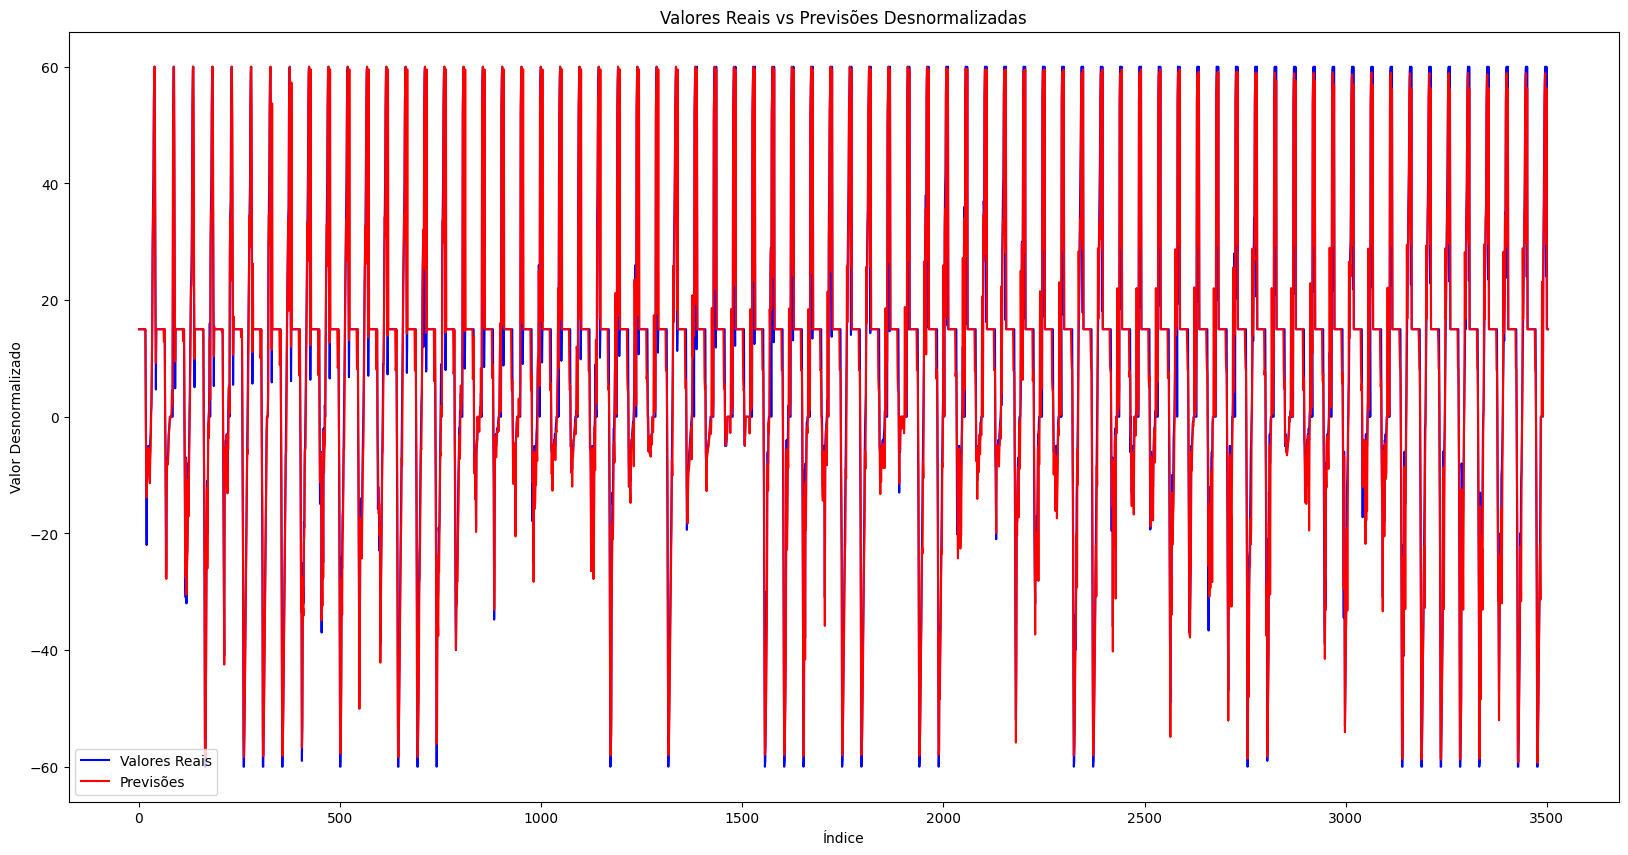

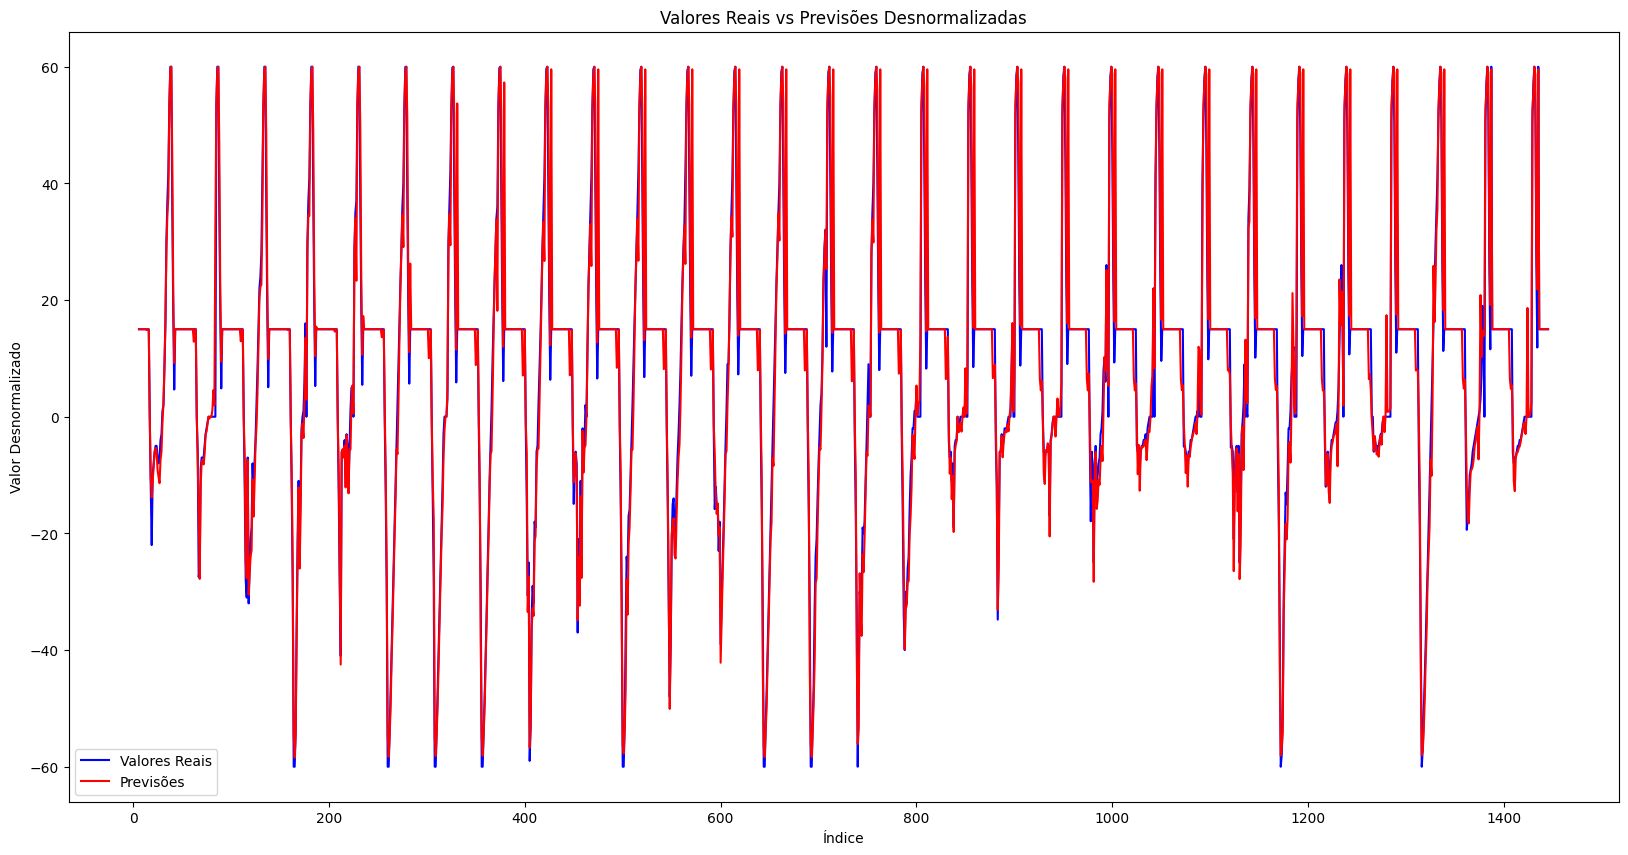

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(y_test_desnormalizado, label='Valores Reais', color='blue')
plt.plot(y_pred_desnormalizado, label='Previsões', color='red')
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()
plt.show()

indices_desejados = range(6,1446)  # 1441 é exclusivo, então inclui até 1440
y_test_selecionado = y_test_desnormalizado[6:1446]  
y_pred_selecionado = y_pred_desnormalizado[6:1446]

plt.figure(figsize=(20, 10))
plt.plot(indices_desejados, y_test_selecionado, label='Valores Reais', color='blue')
plt.plot(indices_desejados, y_pred_selecionado, label='Previsões', color='red')
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()
plt.show()


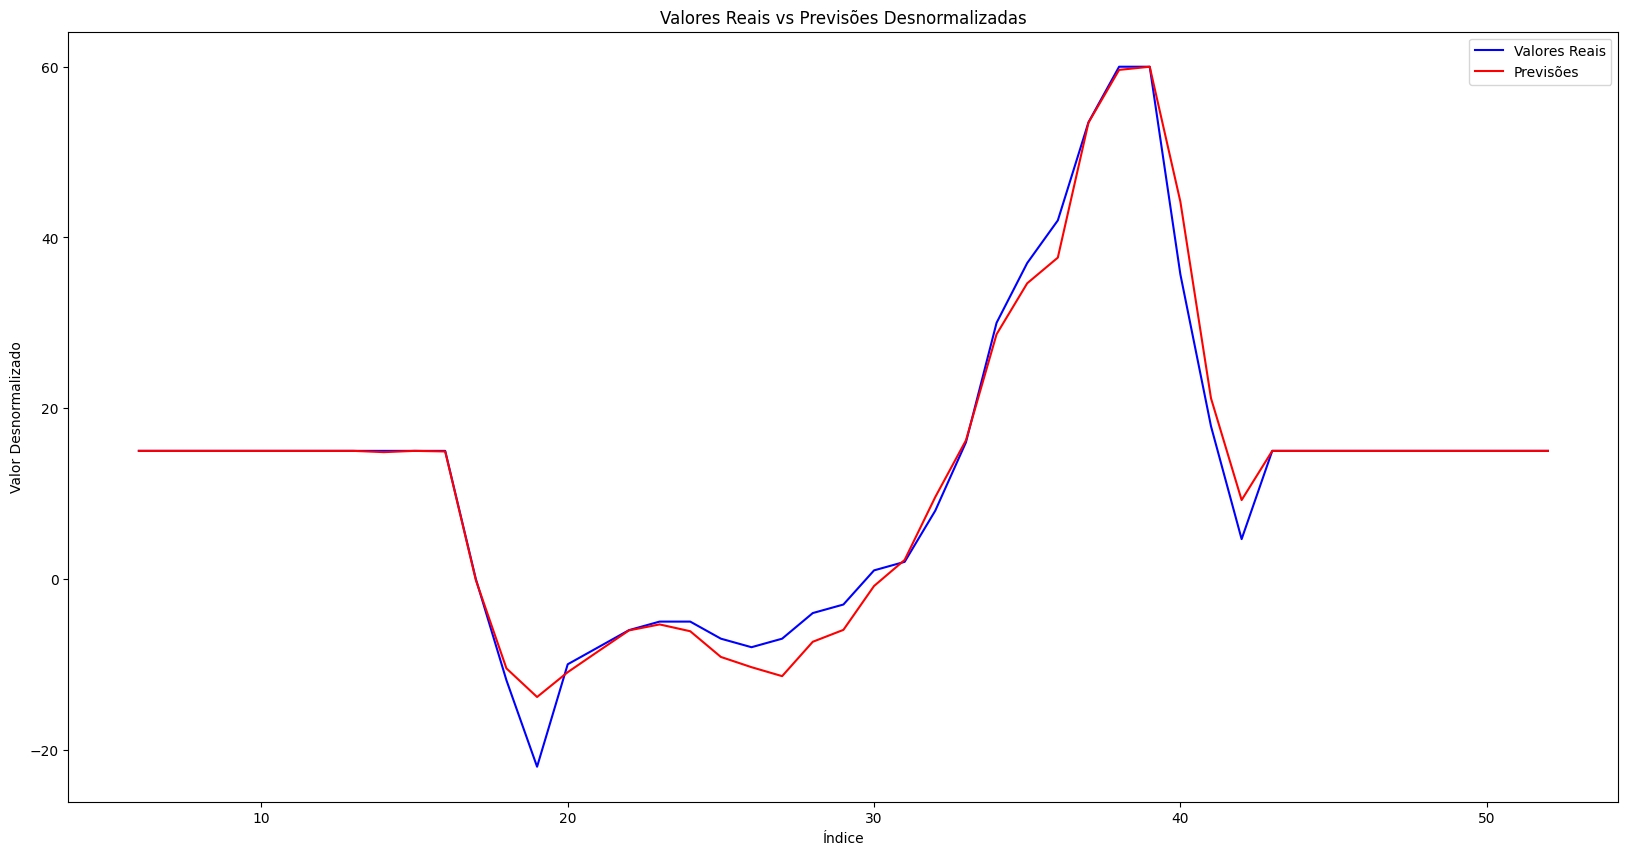

In [15]:
# 30/10 Ensolarado
indices_desejados = range(6,53)  # 1441 é exclusivo, então inclui até 1440
y_test_selecionado = y_test_desnormalizado[6:53]  
y_pred_selecionado = y_pred_desnormalizado[6:53]  

plt.figure(figsize=(20, 10))
plt.plot(indices_desejados, y_test_selecionado, label='Valores Reais', color='blue')
plt.plot(indices_desejados, y_pred_selecionado, label='Previsões', color='red')
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()
plt.show()